# Установка библиотек

In [87]:
"""
pip install --upgrade gensim
pip install pipreqs opencv-python
pip install tensorflow
!pip install Flask
!pip install scikit-learn
!pip install dill
pip install pipreqs
pip install bentoml scikit-learn pandas
pip install wordcloud
!pip install pymorphy2
!python3 -m spacy download ru_core_news_sm
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
"""

'\npip install --upgrade gensim\npip install pipreqs opencv-python\npip install tensorflow\n!pip install Flask\n!pip install scikit-learn\n!pip install dill\npip install pipreqs\npip install bentoml scikit-learn pandas\npip install wordcloud\n!pip install pymorphy2\n!python3 -m spacy download ru_core_news_sm\n!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz\n'

In [88]:
import requests
import re
import pandas as pd
import numpy as np
import nltk
import os 
import json
import dill as pickle
import time
import sys
import sklearn
import matplotlib.pyplot as plt
import spacy

from bs4 import BeautifulSoup
from wordcloud import WordCloud
import string
from tqdm.notebook import tqdm_notebook, tqdm
from sklearn.linear_model import LinearRegression
from collections import Counter
from flask import Flask, jsonify, abort, make_response, request
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

nltk.download('stopwords')
nltk.download('punkt')  # Загружаем необходимые данные NLTK для токенизации

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kayle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kayle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Разработка парсера для сбора данных с  рекомендованных веб-ресурсов

В набор включены все предоставленные данные
Набор  данных дополнен информацией из аналитических статей Интернет-источников
Определены и обоснованы наиболее значимые атрибуты

In [94]:
def get_pages_links(url:str, lists:list = [])->list:#Метод извлекает все ссылки с начальной страницы
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    try:
        lists.append(url)
        next_page_link = "https://habr.com" + soup.find('a', id='pagination-next-page')["href"]
        get_pages_links(next_page_link, lists)
    except:
        pass
    return lists

def get_posts_links_by_page_url(page_url: str)-> list: #Метод выполняет обход всех публикаций по извлеченным ссылкам
    posts_links = []
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    for post_link in soup.find_all('a', class_='tm-title__link'):
        link = "https://habr.com" + post_link["href"]
        posts_links.append(link)
    return posts_links

def get_all_posts_links(company_url):#Метод извлекает все ссылки с постов
    pages_links = get_pages_links(company_url)
    linkes = []
    for link in pages_links:
        linkes.append(get_posts_links_by_page_url(link))
    flat_list = [item for sublist in linkes for item in sublist]
    return list(set(flat_list))

def get_profile_info(profile_url)->dict:
    response = requests.get(profile_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    categories = soup.findAll("a", class_ = "tm-company-profile__categories-text")
    category_list = []
    for category in categories:
        if category is None: continue
        category_list.append(category.get_text())
        
    data = {
        "rating_company" : soup.find("span", class_ = "tm-votes-lever__score-counter").get_text(),
        "desc_company" : soup.find("div", class_ = "tm-company-card__description").get_text(),
        "category_list_company" : category_list,
        "about_company" : soup.find("span", class_ = "tm-company-profile__content").get_text()
    }
    return data

def get_company_post_info(post_url):
    response = requests.get(post_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    tags_post = []
    tags = soup.findAll("a", class_ = "tm-article-snippet__hubs-item-link") 
    for tag in tags:
        tags_post.append(tag.get_text())
        
    labels_post = []
    labels = soup.findAll("div", class_ = "tm-article-snippet__label") 
    for label in labels:
        labels_post.append(label.get_text()) 
    tag = soup.find("span", class_="tm-article-complexity__label")
    if tag is not None:
        difficulty_post = tag.get_text()
    else:
        difficulty_post = "No label found"
    reading_time = soup.find("span", class_="tm-article-reading-time__label")
    if reading_time is not None:
        reading_time_post = re.findall(r'\d+', reading_time.get_text())[0]
    else:
        reading_time_post = "N/A"
        
    views_count = soup.find("span", class_="tm-icon-counter__value")
    if views_count is not None:
        views_count_post = re.findall(r'\d+\.\d+|\d+', views_count.get_text())[0]
    else:
        views_count_post = "N/A"
    data = {
        "name_post": soup.find("h1", class_ = "tm-title tm-title_h1").get_text(),
         "difficulty_post" : difficulty_post,
        "reading_time_post" : reading_time_post,
        "views_count_post" : views_count_post,
        "tags_post" : tags_post,
        "text_post" : soup.find("div", class_="tm-article-body").get_text()

    }
    return data

# Парсер выполняет обход всех публикаций по извлеченным ссылкам с начальной страницы

In [96]:
def parse(companies_urls, posts):
    for company_url in tqdm_notebook(companies_urls):
        if company_url is None: continue
        urls_posts = get_all_posts_links(company_url + "/blog/")
        profile_company = get_profile_info(company_url +"/profile/")
        
        for url in tqdm(urls_posts):
            if not (url is None):
                post = get_company_post_info(url)
                post.update(profile_company)
                posts.append(post)

In [97]:
a = None
type(a)

NoneType

a is {{a}}

In [98]:
companies_urls = [
    "https://habr.com/ru/companies/avito",
    "https://habr.com/ru/companies/vtb",
]
posts = []
parse(companies_urls, posts)


  0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\kayle\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'habr.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\kayle\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'habr.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\kayle\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'habr.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warn

  0%|          | 0/376 [00:00<?, ?it/s]

c:\Users\kayle\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'habr.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\kayle\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'habr.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\kayle\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'habr.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warn

ConnectTimeout: HTTPSConnectionPool(host='habr.com', port=443): Max retries exceeded with url: /ru/companies/avito/articles/501698/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001DA8EB99FD0>, 'Connection to habr.com timed out. (connect timeout=None)'))

In [ ]:
"""
"https://habr.com/ru/companies/vk",
"https://habr.com/ru/companies/alfa",
"https://habr.com/ru/companies/kaspersky",
"https://habr.com/ru/companies/rosatom",
"https://habr.com/ru/companies/rostelecom",
"https://habr.com/ru/companies/spbifmo",
"https://habr.com/ru/companies/sbermarket",
"https://habr.com/ru/companies/agima",
"https://habr.com/ru/companies/mkb",
"https://habr.com/ru/companies/tensor"
"""

'\n"https://habr.com/ru/companies/vk",\n"https://habr.com/ru/companies/alfa",\n"https://habr.com/ru/companies/kaspersky",\n"https://habr.com/ru/companies/rosatom",\n"https://habr.com/ru/companies/rostelecom",\n"https://habr.com/ru/companies/spbifmo",\n"https://habr.com/ru/companies/sbermarket",\n"https://habr.com/ru/companies/agima",\n"https://habr.com/ru/companies/mkb",\n"https://habr.com/ru/companies/tensor"\n'

In [ ]:
df1 = pd.DataFrame(posts)
df1.head()

,name_post,difficulty_post,reading_time_post,views_count_post,tags_post,text_post,rating_company,desc_company,category_list_company,about_company
0,Ультимативный гайд по HTTP. Структура запроса ...,\n Простой\n,9,55,[],"Привет! Меня зовут Ивасюта Алексей, я техлид ...",\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...
1,"Материалы с VLDB, конференции о будущем баз да...",No label found,4,5,[],"Конференция VLDB (Very Large Data Bases, www....",\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...
2,Аналитики данных в Авито: ожидания и спектр задач,No label found,10,17,[],"Привет, я Дина Симкина, директор по аналитике...",\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...
3,Отчет и материалы SPA meetup'а 8 апреля 2017,No label found,4,6.7,[],\n\r\nВ прошедшую субботу в офисе Avito проше...,\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...
4,Как мы внедряли Agile-testing,No label found,7,23,[],"Привет! Меня зовут Алёна Исакова, я ведущий т...",\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...


In [ ]:
with open('Gett.json',errors="ignore")as project_file: 
    data = json.load(project_file)  
with open('skillbox.json',errors="ignore")as project_file: 
    data = json.load(project_file)
with open('Здоровье.ру.json',errors="ignore")as project_file: 
    data = json.load(project_file)
with open('Иннотех.json',errors="ignore")as project_file: 
    data = json.load(project_file)
with open('gg.json',errors="ignore")as project_file: 
    data = json.load(project_file)
with open('Промобот.json',errors="ignore")as project_file: 
    data = json.load(project_file)

df2 = pd.json_normalize(data)

In [ ]:
frames = [df1, df2]
  
df = pd.concat(frames)

# Парсинг веб-сайтов сохраняет полученные интернет-данные в файлы

In [ ]:
# Выполняем GET-запрос к веб-сайту
response = requests.get('https://habr.com/ru/companies/avito')

# Проверяем успешность запроса
if response.status_code == 200:
    # Сохраняем содержимое ответа в текстовый файлЫ
    with open('example.html', 'w', encoding='utf-8') as f:
        f.write(response.text)
        print('Данные сохранены в файл example.html')
else:
    print('Ошибка при выполнении запроса:', response.status_code)

Данные сохранены в файл example.html


# В набор включены все предоставленные данные

In [ ]:
df.columns

Index(['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'tags_post', 'text_post', 'rating_company', 'desc_company',
       'category_list_company', 'about_company', 'info', 'refs', 'refs_quant'],
      dtype='object')

In [ ]:
unique_names = df["name_post"].unique()
unique_names

array(['Ультимативный гайд по HTTP. Структура запроса и ответа',
       'Материалы с VLDB, конференции о будущем баз данных',
       'Аналитики данных в Авито: ожидания и спектр задач',
       "Отчет и материалы SPA meetup'а 8 апреля 2017",
       'Как мы внедряли Agile-testing',
       'Avito Product Analytics Meetup 9 декабря: анонс',
       'OSCP: как я сдавал самый известный экзамен по информационной безопасности',
       'Разбираем iOS-приложение Avito: Ask Me Anything',
       'Межсервисная авторизация в Авито PaaS',
       'Материалы митапа для аналитиков: ценообразование, дашборд для SCRUM-команд, построение процессов',
       'Молчание вентиляторов. Google Colab, Javascript и TensorflowJS',
       'Backend United 3: Холодец', 'История хранилища картинок Avito',
       'Netramesh – легковесное service mesh решение',
       'Приключения одного бага или как починить pgx чужими руками',
       'Мутационное тестирование: опыт внедрения на 1500 сервисов',
       'Avito Design Talk: 

# Дополняем набор данных информацией из аналитических статей Интернет-источников

In [ ]:
len(unique_names)

474

# Преобразуем набор данных в требуемый формат

In [ ]:
df.to_csv("init_dataset.csv", index=False)

# Формируем структуры набора данных

Для определения наиболее значимых атрибутов можно выделать два подхода:

1) выделение целвой перменной (номинация премии Рунета) и использование алгоритмов на основе деревьев (Random Forest, Gradient Boosting)

2) анализ корреляции (Correlation Analysis)

3) Знание предметной области и опыт

4) Исследовательский анализ данных (EDA) т.е. визуализация

Так как использвоание 1-2 и 4 пунктов невозиожно без подготовки данных, то впоспользуемся третьим способом.

Основной массив данных для определения тематика - это текст статей, опубликованных компаниями. В то же время, заголовок статьи и ее категории наиболее емко отражают сожержание.

Поэтому логично, что наиболее важными атрибутами являются:

-текст статьи (text_post)

-название статьи (name_post)

-категории статьи (category_list_company)

In [ ]:
NOMINATIONS = [
    "Государство и Общество",
    "Культурные проекты в сети",
    "Народов много - Родина одна",
    "Образование и Кадры",
    "Наука, технологии и инновации",
    "Туризм и индустрия гостеприимства",
    "Экономика и Бизнес",
    "Здоровье и медицина",
    "Туризм и индустрия гостеприимства",
    "Подкасты и цифровой контент"
    ]

В датасет дополнительно были добавлены следующие атрибуты:

    difficulty_post - сложность понимания поста

    reading_time_post - время чтения поста

    views_count_post - кол-во просмотров

    tags_post - теги постов

    rating_company - райтинг постов

    desc_company - описание комапнии

    category_list_company - категории компании

Атрибуты difficulty_post, reading_time_post, views_count_post, rating_company не окажут сильного влияния на целевую переменную, тем не менее будет интресно посмотреть на различные зависимости кластеров от этих атрибутов.

category_list_company, desc_company могут оказать влияние на целевую переменную

# Предварительная обработка данных

## Выполняем разведочный анализ данных для составления плана предварительной обработки данных

Удалим пока аттрибуты представленные списками

In [ ]:
df_explore = df[['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'text_post', 'rating_company',
       'desc_company', 'about_company']]

Shape of the DataFrame: (852, 13)
Columns in the DataFrame: Index(['name_post', 'difficulty_post', 'reading_time_post', 'views_count_post',
       'tags_post', 'text_post', 'rating_company', 'desc_company',
       'category_list_company', 'about_company', 'info', 'refs', 'refs_quant'],
      dtype='object')
Data types of the columns:
 name_post                 object
difficulty_post           object
reading_time_post         object
views_count_post          object
tags_post                 object
text_post                 object
rating_company            object
desc_company              object
category_list_company     object
about_company             object
info                      object
refs                      object
refs_quant               float64
dtype: object
Summary statistics of the DataFrame:
        refs_quant
count         1.0
mean         21.0
std           NaN
min          21.0
25%          21.0
50%          21.0
75%          21.0
max          21.0
Word count statistic

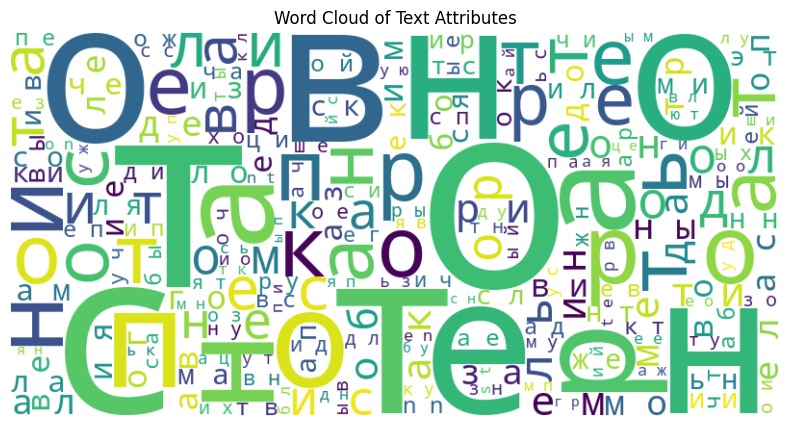

In [ ]:
# Исследование базовых данных
print("Shape of the DataFrame:", df.shape)  # Получиаем количество строк и столбцов
print("Columns in the DataFrame:", df.columns)  # Получиаем имена столбцов
print("Data types of the columns:\n", df.dtypes)  # Получаем типы данных столбцов
print("Summary statistics of the DataFrame:\n", df.describe())  # Получаем сводную статистику

# Исследуем текстовые данные
# Выполняем задачи поиска текстовых данных, такие как подсчет слов, количество уникальных слов и т.д.
# Количество слов
df['word_count'] = df['text_post'].apply(lambda x: len(str(x).split()))
print("Word count statistics:\n", df['word_count'].describe())

# Количество уникальных слов
df['unique_word_count'] = df['text_post'].apply(lambda x: len(set(str(x).split())))
print("Unique word count statistics:\n", df['unique_word_count'].describe())

# Количество стоп-слов
stopwords_list = set(stopwords.words('russian'))  # Update with appropriate language
df['stopword_count'] = df['text_post'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords_list]))
print("Stopword count statistics:\n", df['stopword_count'].describe())

# Визуализация данных
# Используя различные библиотеки построения графиков, такие как Matplotlib и WordCloud, для визуализации текстовых данных
# Примеры графиков:
# Облако слов
text = ' '.join(str(df['text_post'].values))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Attributes')
plt.show()

In [ ]:
a = 1

Как видно, разведочный анализ показвает, что в тексте мнодество стом слов. В среднем примерно 1200 слов в каждом посте при этом окло 400 стоп-слов в кажом посте. {{a}}

# Выявяем и обработываем пропуски данных 

Посмотрим наличие пустых значений и визуализируем

In [ ]:
df.isna().sum()

name_post                  1
difficulty_post            1
reading_time_post          1
views_count_post           1
tags_post                  1
text_post                  1
rating_company             1
desc_company               1
category_list_company      1
about_company              1
info                     852
refs                     851
refs_quant               851
word_count                 0
unique_word_count          0
stopword_count             0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

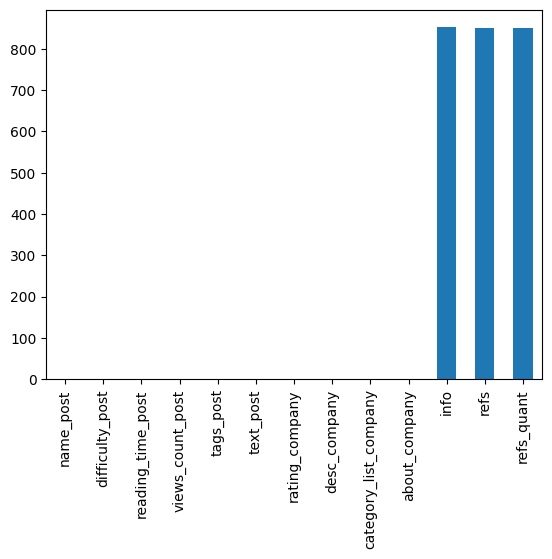

In [ ]:
import matplotlib.pyplot as plt

df.isna().sum().plot(kind='bar')
plt.show

# Выбираем методы предварительной обработки данных

Так как мы работаем с текстовыми данными, необходимо для них выполнить:

очистку данных,

удаление стоп-слов,

лемматизацию,

векторизацию.

Для остальных колонок:

числа, представленные в виде типа object, перевести в численный вид данных,

кодировать категории для дальшейшего обучения моделей

# Удаляем все лишние символы, кроме букв из текстов публикаций. Выполняем токенизацию текстов публикаций. Выполняем лемматизацию текстов публикаций. Выполняем удаление спецсимволов из текстов публикаций. Удаляем все стоп-слова в тектах публикаций

В представленном коде используются несколько алгоритмов для предобработки текстов:

Удаление цифр: re.sub(r'\d+', '', text) - это регулярное выражение, которое удаляет все цифры из текста.

Удаление знаков пунктуации: re.sub(r'[^\w\s]', '', text) - это регулярное выражение, которое удаляет все знаки пунктуации из текста, кроме букв и пробелов.

Удаление лишних пробелов: re.sub(r'\s+', ' ', text) - это регулярное выражение, которое заменяет последовательности из одного или более пробелов одним пробелом.

Удаление стоп-слов: text = [word for word in text.split() if word not in stop_words] - это код, который удаляет стоп-слова из текста. Список стоп-слов загружается из библиотеки NLTK с использованием stopwords.words('russian').

In [ ]:
def text_preprocessing(text):
    stop_words = set(stopwords.words('russian'))
    exclude = set(string.punctuation)

    if text is string:
        text = text.rstrip().lower()
        text = re.sub(r'\n',' ', text) # удалить /n
        text = re.sub(r'\d+', '', text) # удалить цифры
        text = re.sub(r'[^\w\s]', '', text)# убрать знаки препинания
        text = re.sub(r'\s+', ' ', text) # удалите лишние пробелы
        text = [word for word in text.split() if word not in stop_words] # Удаляем стоп-слова

        return text
    return ""
sentences = list(df['text_post'].apply(text_preprocessing))

Создание биграм и триграм: Phrases из библиотеки Gensim используется для создания моделей биграм и триграм на основе предобработанных текстов. Минимальное количество вхождений (min_count) и порог (threshold) используются для настройки этих моделей.

Обновление столбца 'text_post' с предобработанным текстом: df['text_bigram_trigram'] = sentences - это код, который обновляет столбец 'text_bigram_trigram' в DataFrame df с предобработанным текстом, полученным после применения всех алгоритмов предобработки.

In [ ]:
df.head()

,name_post,difficulty_post,reading_time_post,views_count_post,tags_post,text_post,rating_company,desc_company,category_list_company,about_company,info,refs,refs_quant
0,Ультимативный гайд по HTTP. Структура запроса ...,\n Простой\n,9,55,[],"Привет! Меня зовут Ивасюта Алексей, я техлид ...",\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...,NaN,NaN,NaN
1,"Материалы с VLDB, конференции о будущем баз да...",No label found,4,5,[],"Конференция VLDB (Very Large Data Bases, www....",\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...,NaN,NaN,NaN
2,Аналитики данных в Авито: ожидания и спектр задач,No label found,10,17,[],"Привет, я Дина Симкина, директор по аналитике...",\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...,NaN,NaN,NaN
3,Отчет и материалы SPA meetup'а 8 апреля 2017,No label found,4,6.7,[],\n\r\nВ прошедшую субботу в офисе Avito проше...,\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...,NaN,NaN,NaN
4,Как мы внедряли Agile-testing,No label found,7,23,[],"Привет! Меня зовут Алёна Исакова, я ведущий т...",\n 147.36\n,У нас живут ваши объявления,"[\n Веб-разработка\n ,...",Мы команда инженеров Авито. В блоге рассказыва...,NaN,NaN,NaN


Визуализируем результат

In [ ]:
# Создаем облако тегов
tags = df['tags_post'].explode()
tags_counter = Counter(tags)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tags_counter)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags')
plt.show()

# Создаем облако категорий
categories = df['category_list_company'].explode()
categories_counter = Counter(categories)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(categories_counter)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Categories')
plt.show()

# ошибка TypeError: argument of type 'float' is not iterable

TypeError: argument of type 'float' is not iterable

In [ ]:
#Удалены все лишние символы, кроме букв из текстов публикаций
def remove_special_chars(text):
    """
    Remove special characters and digits from text.
    """
    return re.sub(r'[^а-яА-Я\s]', '', text)

#Удалены все стоп-слова в тектах публикаций
def remove_stopwords(text):
    """
    Remove stop words from text.
    """
    stop_words = stopwords.words('russian')
    return ' '.join([word for word in text.split() if word not in stop_words])

# Выполнена лемматизация текстов публикаций
def lemmatize(text):
    """
    Lemmatize text using pymorphy2.
    """
    morph = MorphAnalyzer()
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])

In [ ]:
# Применяем функцию remove_special_chars() к столбцу с именем 'text_column'
df['text_clear'] = df['text_post'].apply(remove_special_chars)

# Применяем функцию remove_stopwords() к столбцу с именем 'text_column'
df['text_clear'] = df['text_clear'].apply(remove_stopwords)

# Применяем lemmatize() к столбцу с именем 'text_column'
df['text_clear'] = df['text_clear'].apply(lemmatize)

In [ ]:
# Определяем функцию для обозначения русского текста с помощью NLTK
def tokenize_russian_text(text):
    tokens = nltk.word_tokenize(text, language='russian')
    return tokens

# Применяем функцию токенизации к столбцу "текст" во фрейме данных
df['tokens'] = df['text_clear'].apply(tokenize_russian_text)

# Отображаем результирующий фрейм данных
df.head()

In [ ]:
nlp = spacy.load("ru_core_news_sm")

In [ ]:
# Загружаем данные в dataframe
# Определяем функцию для выполнения тегов частей речи и выделения значимых частей речи
def highlight_pos(text):
    doc = nlp(text)
    highlighted_text = ""
    for token in doc:
        if token.pos_ in ["NOUN", "VERB"]:   # Определяем значимые части речи
            highlighted_text += f"{token.text} " # Добавляем HTML-теги для выделения
    return highlighted_text

# Применяем функцию к столбцу маркированного текста во фрейме данных

df["highlighted_text"] = df["text_clear"].apply(highlight_pos)

# Распечатываем обновленный фрейм данных
df.head()